In [1]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt


def generate_trajectories(n_trajectories=50, random_state=42):
    """Generuje syntetyczne trajektorie GPS."""
    np.random.seed(random_state)
    trajectories = []

    # Typ 1: Trasa do centrum (z różnych stron)
    for _ in range(15):
        length = np.random.randint(20, 40)
        start = np.random.randn(2) * 5 + np.array([10, 10])
        end = np.array([0, 0])  # centrum
        t = np.linspace(0, 1, length).reshape(-1, 1)
        traj = start + t * (end - start) + np.random.randn(length, 2) * 0.3
        trajectories.append(traj)

    # Typ 2: Trasa rekreacyjna (pętla)
    for _ in range(15):
        length = np.random.randint(30, 50)
        t = np.linspace(0, 2 * np.pi, length)
        r = 3 + np.random.rand() * 2
        traj = np.column_stack([r * np.cos(t), r * np.sin(t)])
        traj += np.random.randn(length, 2) * 0.2
        trajectories.append(traj)

    # Typ 3: Trasa wzdłuż rzeki (liniowa)
    for _ in range(20):
        length = np.random.randint(25, 45)
        start_x = np.random.rand() * 10 - 5
        x = np.linspace(start_x, start_x + 8, length)
        y = np.sin(np.linspace(0, np.pi, length)) * 2
        traj = np.column_stack([x, y])
        traj += np.random.randn(length, 2) * 0.2
        trajectories.append(traj)

    return trajectories


def dtw_distance(traj1, traj2):
    """Oblicza odległość DTW między dwiema trajektoriami."""
    n, m = len(traj1), len(traj2)
    
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(traj1[i - 1] - traj2[j - 1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],
                dtw_matrix[i, j - 1],
                dtw_matrix[i - 1, j - 1]
            )
    
    return dtw_matrix[n, m]


def compute_dtw_matrix(trajectories):
    """Oblicza macierz odległości DTW."""
    n = len(trajectories)
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = dtw_distance(trajectories[i], trajectories[j])
            D[i, j] = dist
            D[j, i] = dist
    
    return D

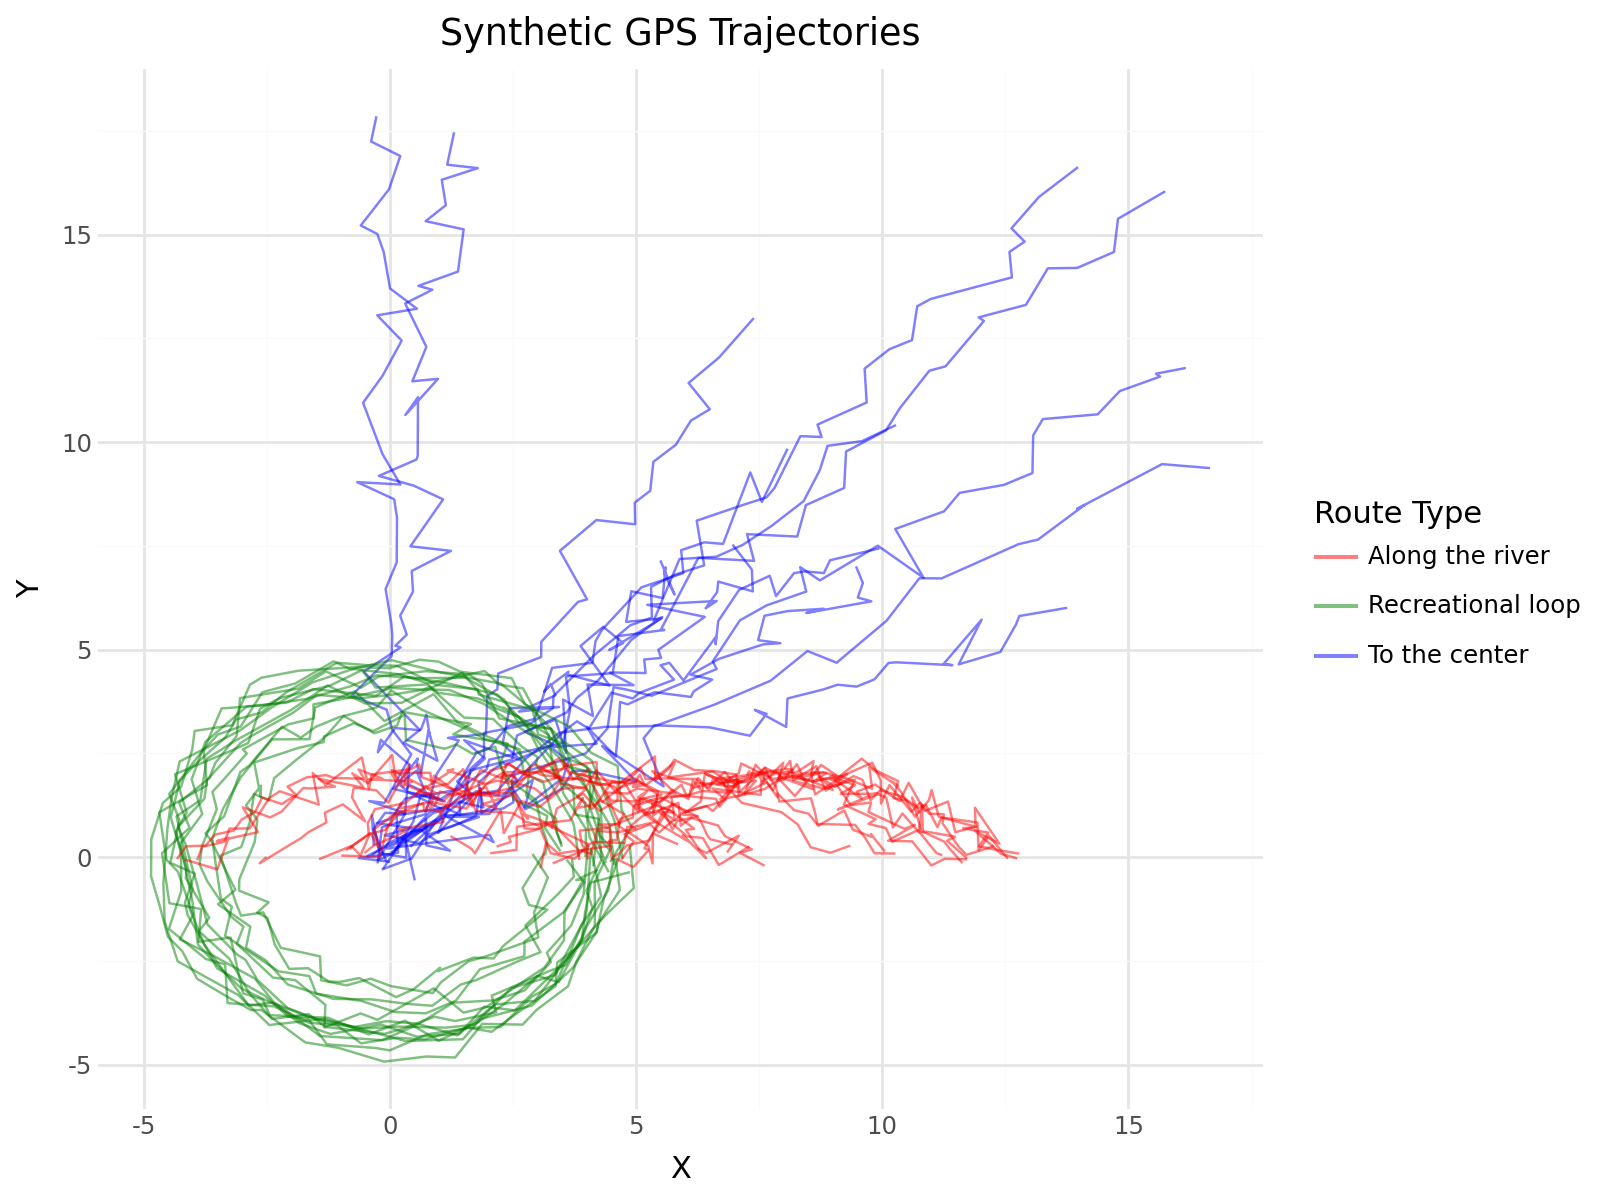

In [2]:
import pandas as pd
from plotnine import *

trajectories = generate_trajectories()

data = []
for i, traj in enumerate(trajectories):
    typ = "To the center" if i < 15 else "Recreational loop" if i < 30 else "Along the river"
    for j, point in enumerate(traj):
        data.append({'x': point[0], 'y': point[1], 'traj_id': i, 'typ': typ, 'order': j})
  
(ggplot(pd.DataFrame(data), aes(x='x', y='y', group='traj_id', color='typ'))
    + geom_path(alpha=0.5)
    + scale_color_manual(values=['red', 'green', 'blue'])
    + labs(title='Synthetic GPS Trajectories', x='X', y='Y', color='Route Type')
    + theme_minimal() + theme(figure_size=(8, 6))
)

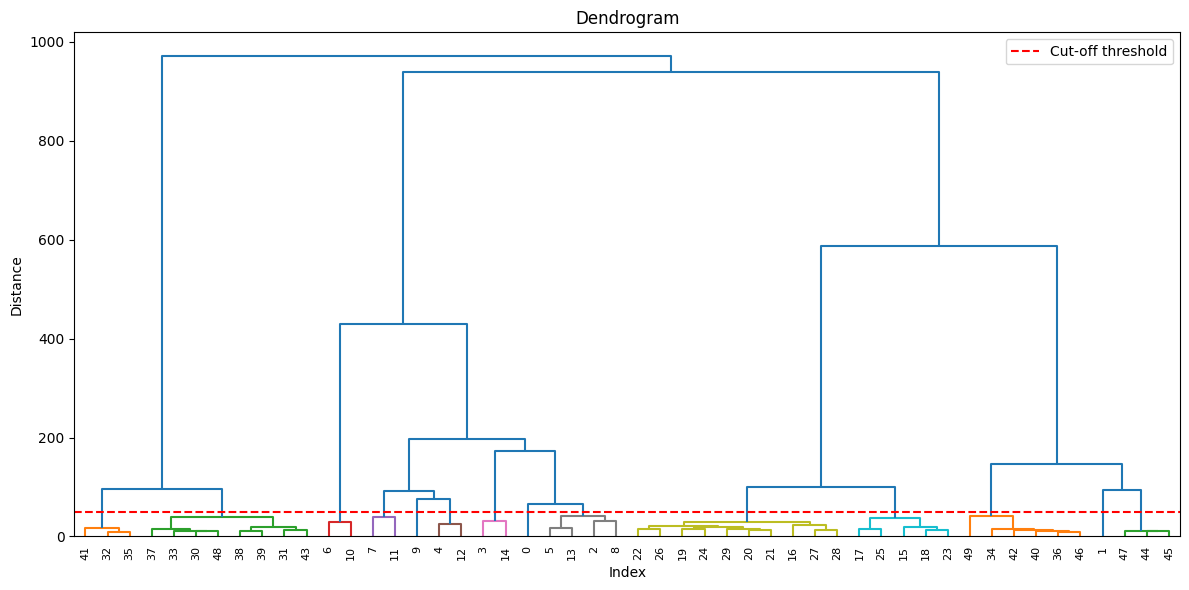

In [3]:
D = compute_dtw_matrix(trajectories)
D_condensed = squareform(D)

Z = linkage(D_condensed, method='ward')

fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(
    Z,
    ax=ax,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=50
)
ax.set_title('Dendrogram')
ax.set_xlabel('Index')
ax.set_ylabel('Distance')
ax.axhline(y=50, color='r', linestyle='--', label='Cut-off threshold')
ax.legend()
plt.tight_layout()
plt.show()

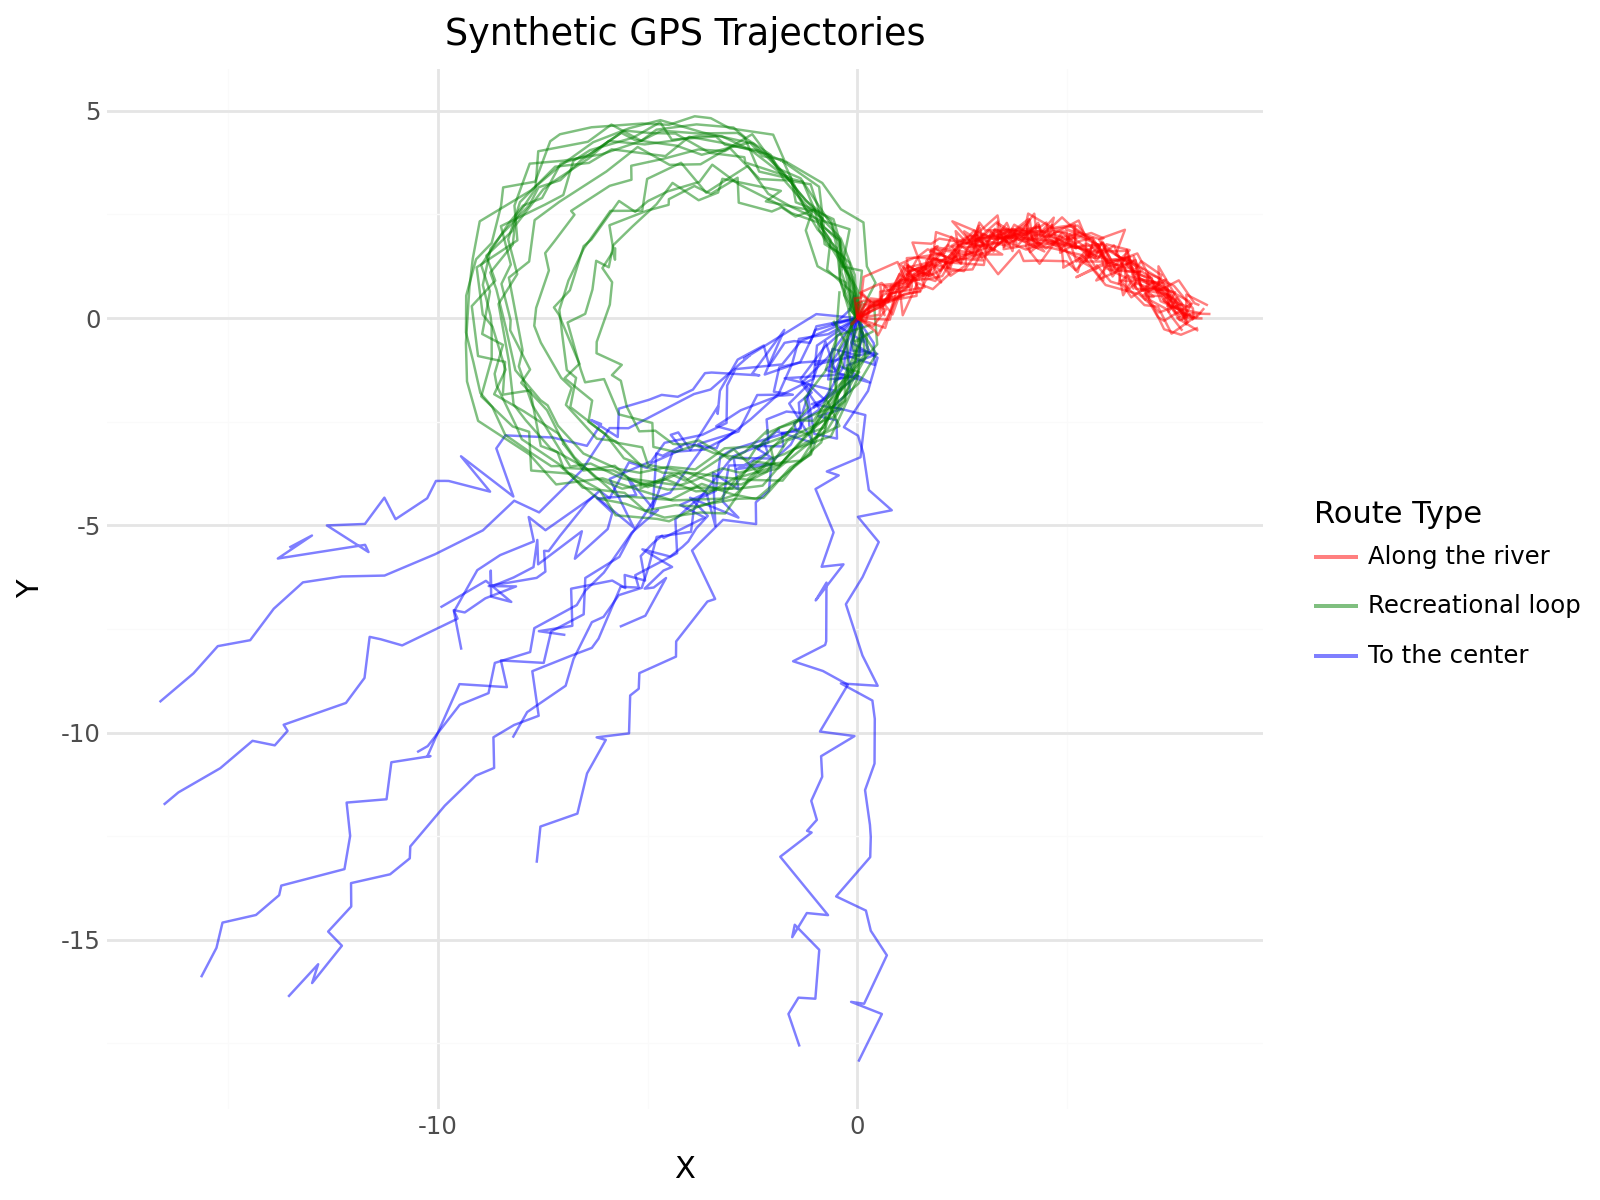

In [4]:
def normalize_trajectory(traj):
    return (traj - traj[0]) # / np.max(np.abs(traj - traj[0]))

traj_norm = [normalize_trajectory(t) for t in trajectories]

data = []
for i, traj in enumerate(traj_norm):
    typ = "To the center" if i < 15 else "Recreational loop" if i < 30 else "Along the river"
    for j, point in enumerate(traj):
        data.append({'x': point[0], 'y': point[1], 'traj_id': i, 'typ': typ, 'order': j})
  
(ggplot(pd.DataFrame(data), aes(x='x', y='y', group='traj_id', color='typ'))
    + geom_path(alpha=0.5)
    + scale_color_manual(values=['red', 'green', 'blue'])
    + labs(title='Synthetic GPS Trajectories', x='X', y='Y', color='Route Type')
    + theme_minimal() + theme(figure_size=(8, 6))
)

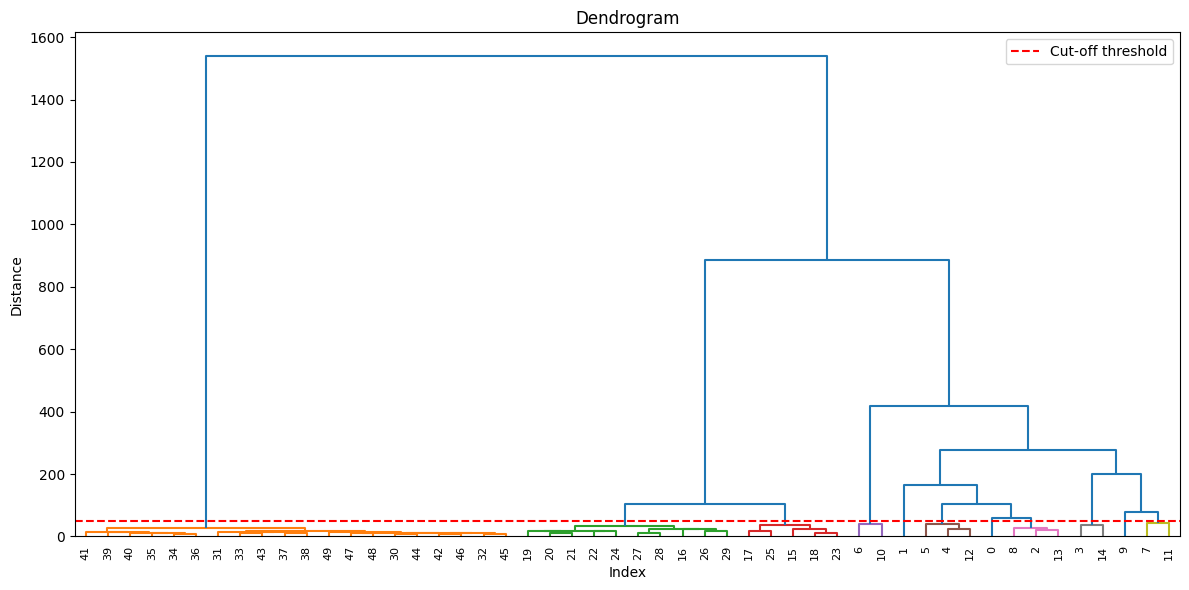

In [5]:
D = compute_dtw_matrix(traj_norm)
D_condensed = squareform(D)

Z = linkage(D_condensed, method='ward')

fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(
    Z,
    ax=ax,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=50
)
ax.set_title('Dendrogram')
ax.set_xlabel('Index')
ax.set_ylabel('Distance')
ax.axhline(y=50, color='r', linestyle='--', label='Cut-off threshold')
ax.legend()
plt.tight_layout()
plt.show()

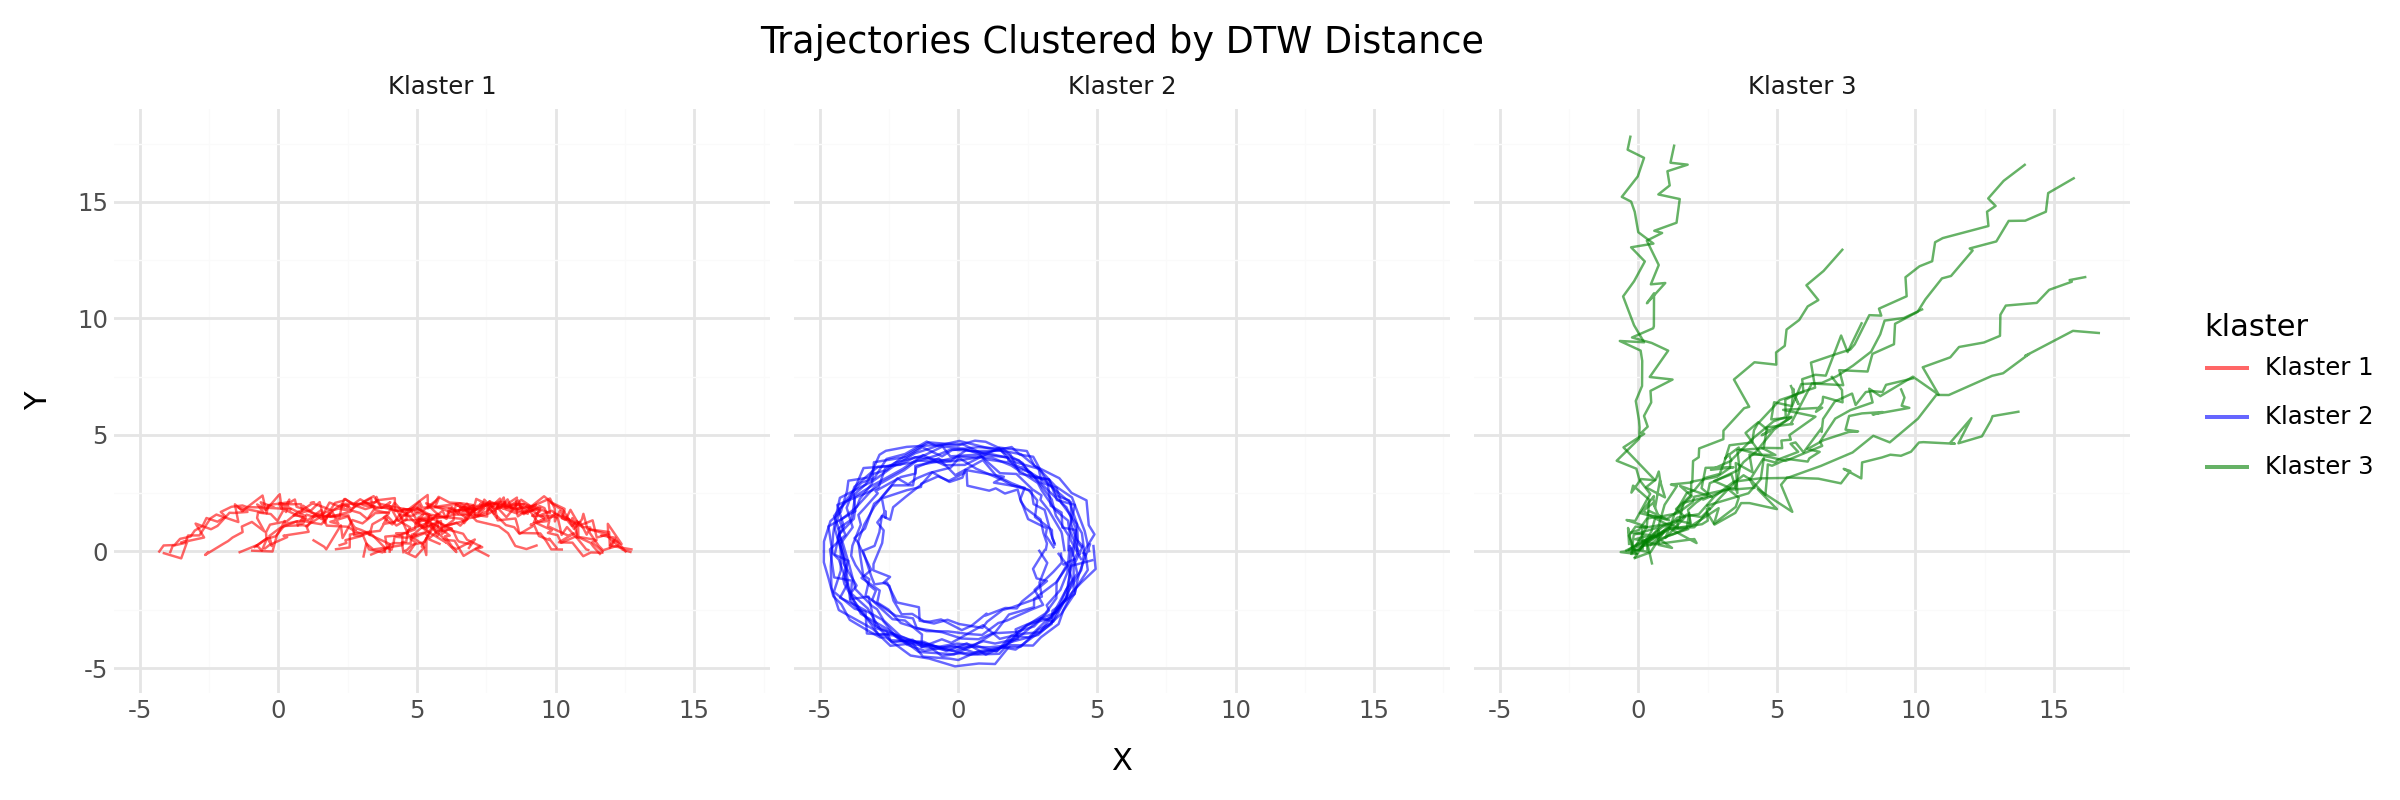

In [6]:
clusters = fcluster(Z, 3, criterion='maxclust')

data_clustered = []
for i, traj in enumerate(trajectories):
    for j, point in enumerate(traj):
        data_clustered.append({
            'x': point[0],
            'y': point[1],
            'traj_id': i,
            'klaster': f'Klaster {clusters[i]}',
            'order': j
        })

df_clustered = pd.DataFrame(data_clustered)

(
    ggplot(df_clustered, aes(x='x', y='y', group='traj_id', color='klaster'))
    + geom_path(alpha=0.6)
    + facet_wrap('~klaster')
    + scale_color_manual(values=['red', 'blue', 'green'])
    + labs(
        title='Trajectories Clustered by DTW Distance',
        x='X', y='Y'
    )
    + theme_minimal()
    + theme(figure_size=(12, 4))
)